# START

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
import swifter
import mlflow
import mlflow.sklearn

/home/kamel/Openclassroom_projets/P7/.p7venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA READING

In [3]:
# Load and preprocess data
df = pd.read_csv("../sentiment140/training.1600000.processed.noemoticon.csv",
                 encoding='latin-1',
                 header=None,
                 names=['sentiment','id','date','query','user','tweet'])

df.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# EDA

## Missing values

In [ ]:
def display_general_info(df):
    """Display general information about the DataFrame"""
    print("1. GENERAL OVERVIEW OF THE DATASET")
    print("-" * 50)
    print(f"Total number of entries: {df.shape[0]:,}")
    print(f"Number of columns: {df.shape[1]}")
    print("\nColumns present:")
    for col in df.columns:
        print(f"- {col}")

    print("\nData types:")
    print(df.dtypes)

    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicated rows: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

display_general_info(df)

1. GENERAL OVERVIEW OF THE DATASET
--------------------------------------------------
Total number of entries: 1,600,000
Number of columns: 6

Columns present:
- sentiment
- id
- date
- query
- user
- tweet

Data types:
sentiment     int64
id            int64
date         object
query        object
user         object
tweet        object
dtype: object

Missing values per column:
sentiment    0
id           0
date         0
query        0
user         0
tweet        0
dtype: int64

Number of duplicated rows: 0 (0.00%)


## Classes balance & Requets

In [9]:
# Studying values in some columns
print(df['sentiment'].value_counts())
print('*****')
print(df['query'].value_counts())

sentiment
0    800000
4    800000
Name: count, dtype: int64
*****
query
NO_QUERY    1600000
Name: count, dtype: int64


In [10]:
df = df[['sentiment','tweet']]
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Words Analyzing

### Words Clouds

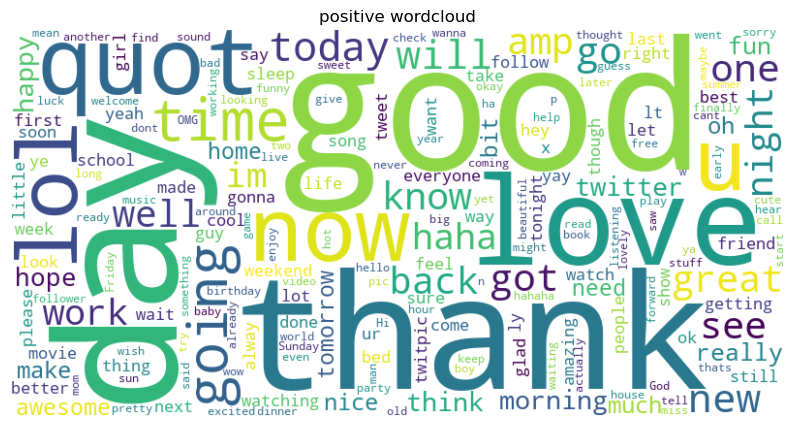

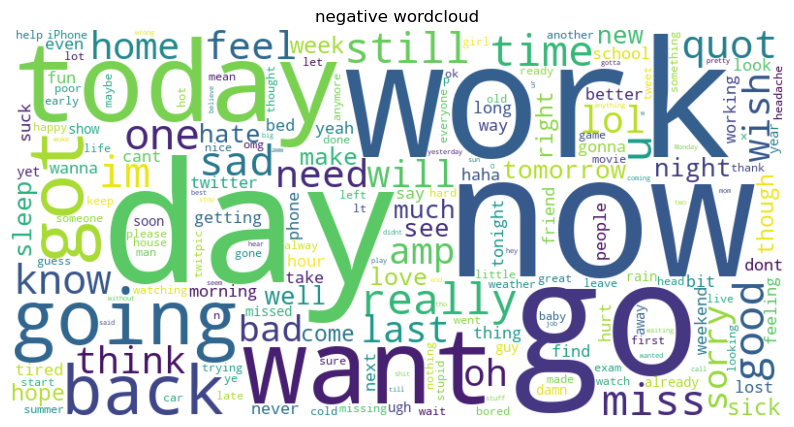

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def display_tweet_wordcloud(df, sentiment='positive', title=None):
    sentiment = sentiment.lower()
    sentiment_filter = {'positive': 4, 'negative': 0}
    if sentiment not in sentiment_filter:
        raise ValueError("sentiment must be either 'positive' or 'negative'")
    if 'tweet' not in df.columns or 'sentiment' not in df.columns:
        raise ValueError("DataFrame must contain 'tweet' and 'sentiment' columns")
    subset = df.loc[df['sentiment'] == sentiment_filter[sentiment], 'tweet']
    if subset.empty:
        print(f'No {sentiment} tweets to display.')
        return
    corpus = ' '.join(subset.astype(str))
    stopwords = STOPWORDS.union({'https', 'co'})
    nuage = WordCloud(width=800, height=400, background_color='white',
                     stopwords=stopwords, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 6))
    plt.imshow(nuage, interpolation='bilinear')
    plt.axis('off')
    if title is None:
        title = f"Most frequent words in {sentiment} tweets"
    plt.title(title)
    plt.show()

display_tweet_wordcloud(df,'positive','positive wordcloud')
print('='*20)
print('='*20)
display_tweet_wordcloud(df,'negative','negative wordcloud')

### Most frequents N-grams

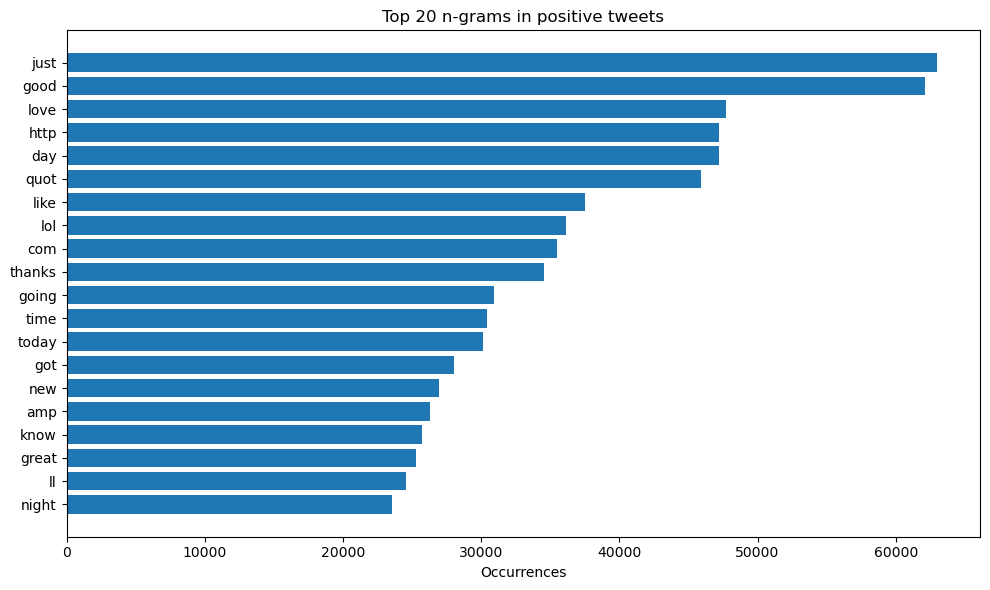

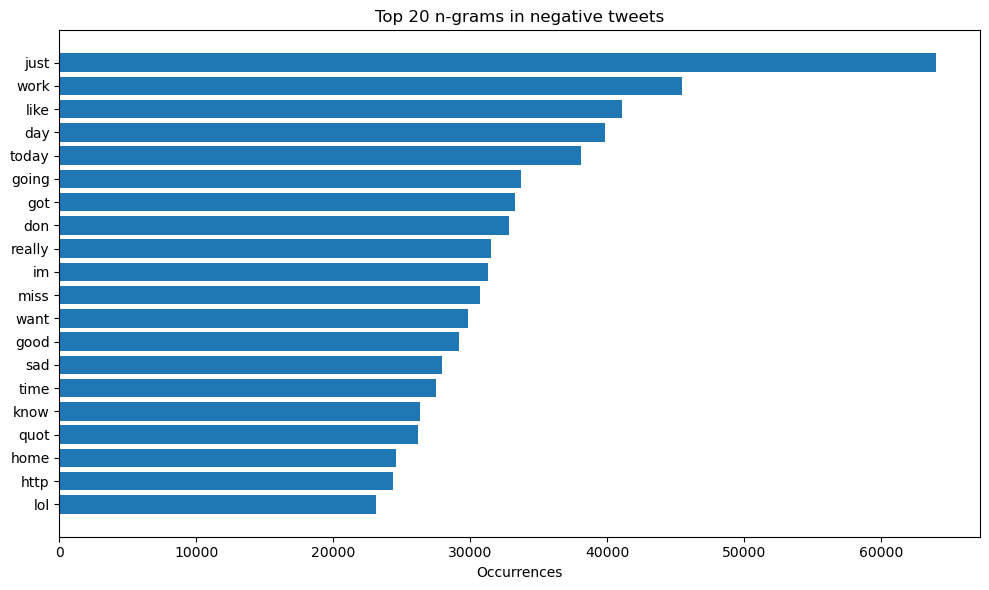

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
# function to display in a histogram to most frequent N-grams in a dataframe tweets according to the selected type sentiment

def _tweets_by_sentiment(df, sentiment):
    sentiment = sentiment.lower()
    sentiment_filter = {'positive': 4, 'negative': 0}
    if sentiment not in sentiment_filter:
        raise ValueError("sentiment must be either 'positive' or 'negative'")
    if 'tweet' not in df.columns or 'sentiment' not in df.columns:
        raise ValueError("DataFrame must contain 'tweet' and 'sentiment' columns")
    subset = df.loc[df['sentiment'] == sentiment_filter[sentiment], 'tweet']
    return subset

def plot_top_ngrams(df, sentiment='positive', ngram_range=(1, 1), top_n=20, title=None):
    subset = _tweets_by_sentiment(df, sentiment)
    if subset.empty:
        print(f'No {sentiment} tweets to display.')
        return

    textes = subset.astype(str)
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    matrice = vectorizer.fit_transform(textes)
    termes = vectorizer.get_feature_names_out()
    if len(termes) == 0:
        print('No terms found for the selected configuration.')
        return
    totaux = matrice.sum(axis=0).A1
    top_n = min(top_n, len(termes))
    if top_n == 0:
        print('No terms to plot.')
        return
    indices = totaux.argsort()[::-1][:top_n]
    top_ngrams = termes[indices]
    top_counts = totaux[indices]
    plt.figure(figsize=(10, 6))
    plt.barh(top_ngrams[::-1], top_counts[::-1])
    plt.xlabel('Occurrences')
    if title is None:
        title = f"Top {top_n} n-grams in {sentiment} tweets"
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_ngrams(df, sentiment='positive', ngram_range=(1, 1), top_n=20, title=None)
print('='*20)
print('='*20)
plot_top_ngrams(df, sentiment='negative', ngram_range=(1, 1), top_n=20)

## Lexical syntaxes Analyzing

### Tweets length

Average tweet length: 74.09 characters
Average word count per tweet: 13.18 words


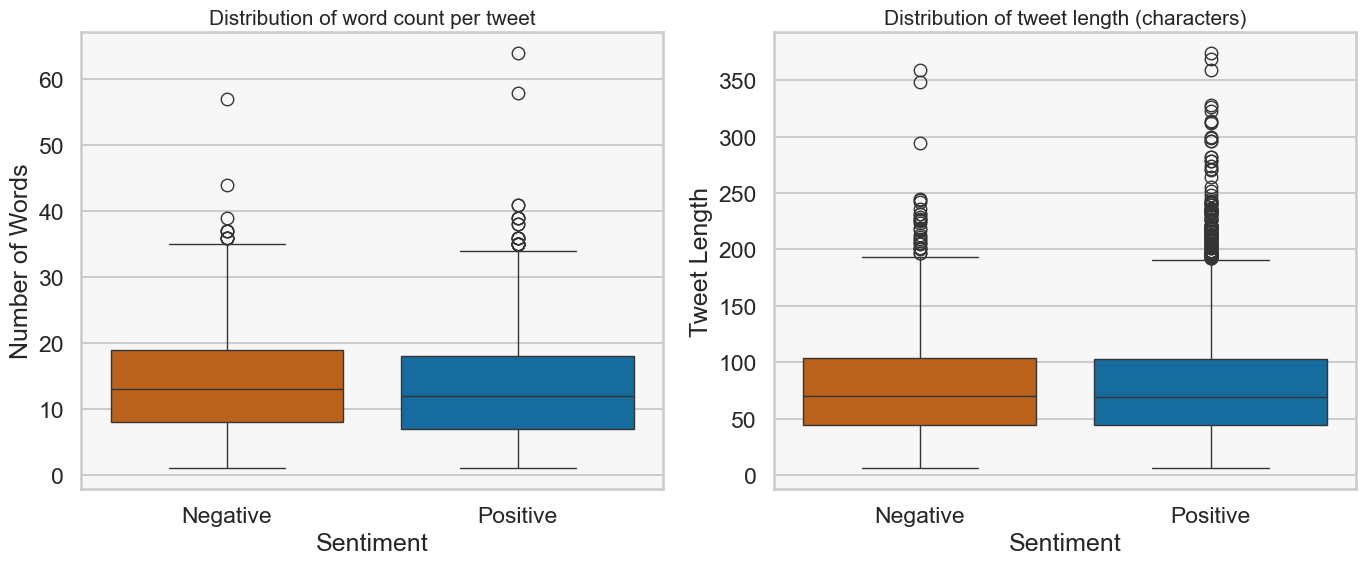

In [4]:
def analyze_tweet_text(df):
    """Analyze textual characteristics of tweets with a clean visualization"""

    # Create new text-related variables
    df['text_length'] = df['tweet'].apply(len)
    df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
    df['sentiment_label'] = df['sentiment'].map({0: 'Negative', 4: 'Positive'})

    print(f"Average tweet length: {df['text_length'].mean():.2f} characters")
    print(f"Average word count per tweet: {df['word_count'].mean():.2f} words")

    # General visualization style
    sns.set(style="whitegrid", context="talk")
    sns.set_style("whitegrid", {"axes.facecolor": "#f7f7f7"})
    custom_palette = {"Negative": "#D55E00", "Positive": "#0072B2"}  # orange/blue

    plt.figure(figsize=(14, 6))

    # ----- Boxplot 1: number of words per tweet -----
    plt.subplot(1, 2, 1)
    sns.boxplot(
        x='sentiment_label',
        y='word_count',
        hue='sentiment_label',        # Added for Seaborn 0.14+ compatibility
        data=df,
        palette=custom_palette,
        legend=False
    )
    plt.title('Distribution of word count per tweet', fontsize=15)
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Words')

    # ----- Boxplot 2: tweet length in characters -----
    plt.subplot(1, 2, 2)
    sns.boxplot(
        x='sentiment_label',
        y='text_length',
        hue='sentiment_label',        # Added for Seaborn 0.14+ compatibility
        data=df,
        palette=custom_palette,
        legend=False
    )
    plt.title('Distribution of tweet length (characters)', fontsize=15)
    plt.xlabel('Sentiment')
    plt.ylabel('Tweet Length')

    # Adjust layout and show plots
    plt.tight_layout()
    plt.show()
    df = df.drop('sentiment_label', axis=1, inplace=True)


analyze_tweet_text(df)

### Negative forms

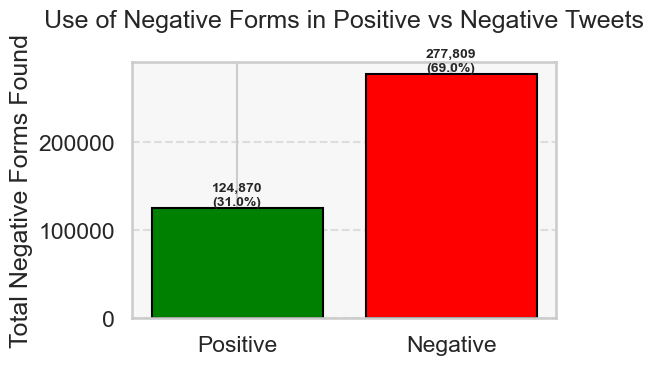

In [5]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def compare_negative_forms(df):
    """
    Count and compare the use of negative forms in positive vs negative tweets.

    Args:
        df (pd.DataFrame): DataFrame with ['sentiment', 'tweet'] columns.

    Returns:
        dict: Dictionary with total and percentage of negative forms for each sentiment.
    """

    # Define what we consider negative forms (regex, case insensitive)
    negative_forms = [
        r"\bnot\b", r"\bno\b", r"\bnever\b", r"\bnone\b", r"\bnothing\b", r"\bnowhere\b",
        r"\bneither\b", r"\bnor\b", r"\bcannot\b", r"\bwithout\b",
        r"\bdon't\b", r"\bdoesn't\b", r"\bdidn't\b", r"\bcan't\b", r"\bcouldn't\b",
        r"\bwon't\b", r"\bwouldn't\b", r"\bshouldn't\b", r"\bisn't\b", r"\baren't\b",
        r"\bwasn't\b", r"\bweren't\b", r"\bhasn't\b", r"\bhaven't\b", r"\bhadn't\b",
        r"\bain't\b", r"n't\b"
    ]
    pattern = re.compile("|".join(negative_forms), flags=re.IGNORECASE)

    # Count occurrences per tweet
    df['neg_form_count'] = df['tweet'].astype(str).apply(lambda x: len(re.findall(pattern, x)))

    # Aggregate totals by sentiment
    pos_total = df.loc[df['sentiment'] == 4, 'neg_form_count'].sum()
    neg_total = df.loc[df['sentiment'] == 0, 'neg_form_count'].sum()

    # Number of tweets by sentiment
    pos_tweets = (df['sentiment'] == 4).sum()
    neg_tweets = (df['sentiment'] == 0).sum()

    # Average per tweet and percentage
    pos_avg = pos_total / pos_tweets if pos_tweets > 0 else 0
    neg_avg = neg_total / neg_tweets if neg_tweets > 0 else 0

    total_all = pos_total + neg_total
    pos_perc = (pos_total / total_all) * 100 if total_all > 0 else 0
    neg_perc = (neg_total / total_all) * 100 if total_all > 0 else 0

    # Bar chart visualization
    sentiments = ['Positive', 'Negative']
    totals = [pos_total, neg_total]
    percentages = [pos_perc, neg_perc]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(sentiments, totals, color=['green', 'red'], edgecolor='black')

    # Add count + percentage labels
    for bar, count, perc in zip(bars, totals, percentages):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{count:,}\n({perc:.1f}%)",
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

    plt.title("Use of Negative Forms in Positive vs Negative Tweets\n")
    plt.ylabel("Total Negative Forms Found")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

compare_negative_forms(df)

### Emoticons


Emoticon sentiment distribution for positive tweets:
                   type  count  percentage
0  positive \nemoticons   7881       87.43
1  negative \nemoticons   1133       12.57


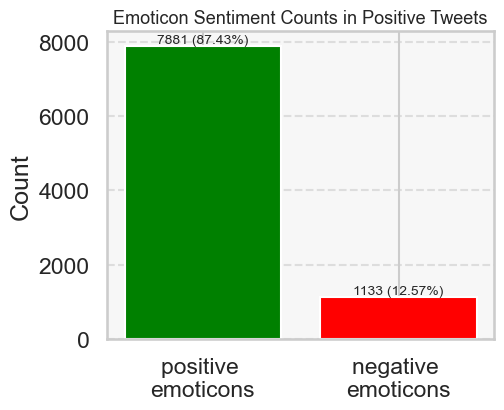


Emoticon sentiment distribution for negative tweets:
                   type  count  percentage
0  positive \nemoticons   6404       69.01
1  negative \nemoticons   2876       30.99


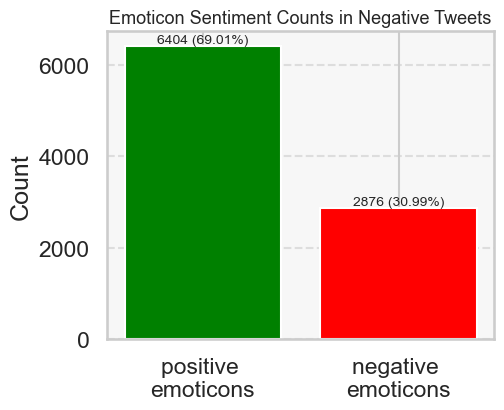

In [6]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

def analyze_emoticons(df, sentiment='positive'):
    """
    Analyze emoticons in tweets according to the chosen sentiment,
    count how many are positive and negative,
    and display the results in a histogram (with percentages).
    """

    # Check sentiment parameter
    if sentiment not in ['positive', 'negative']:
        raise ValueError("The parameter 'sentiment' must be 'positive' or 'negative'.")

    # Filter tweets by sentiment (4 = positive, 0 = negative)
    subset = df[df['sentiment'] == (4 if sentiment == 'positive' else 0)]

    # Regex to extract emoticons (escaped properly)
    emoticon_pattern = r'(:\)|:-\)|:\]|:D|:o\)|:3|:c\)|: c|=\)|=\]|;\)|:-D|<3|:\(|:-\(|:\[|;\(|:\'\(|D:|>\\.<|T_T)'

    # Extract all emoticons
    all_emoticons = []
    for text in subset['tweet'].astype(str):
        all_emoticons.extend(re.findall(emoticon_pattern, text))

    if not all_emoticons:
        print(f"No emoticons found for {sentiment} tweets.")
        return pd.DataFrame(columns=['type', 'count'])

    # Define positive and negative emoticons
    positive_emoticons = {":)", ":-)", ":D", ":-D", ";)", ":]", "<3", ":3", ":o)", "=)", "=]"}
    negative_emoticons = {":(", ":-(", ":'(", "D:", ":c", ": c", ":[", "T_T", ">.<", ";("}

    # Count positive and negative emoticons
    pos_count = sum(1 for e in all_emoticons if e in positive_emoticons)
    neg_count = sum(1 for e in all_emoticons if e in negative_emoticons)
    total = pos_count + neg_count

    # Prepare result DataFrame with percentages
    counts_df = pd.DataFrame({
        'type': ['positive \nemoticons', 'negative \nemoticons'],
        'count': [pos_count, neg_count],
        'percentage': [round((pos_count/total)*100, 2) if total else 0,
                       round((neg_count/total)*100, 2) if total else 0]
    })

    # Print result
    print(f"\nEmoticon sentiment distribution for {sentiment} tweets:")
    print(counts_df)

    # Plot histogram
    plt.figure(figsize=(5,4))
    colors = ['green', 'red']
    bars = plt.bar(counts_df['type'], counts_df['count'], color=colors)
    plt.title(f"Emoticon Sentiment Counts in {sentiment.capitalize()} Tweets", fontsize=13)
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.6)


    # Add count + percentage labels
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        pct = counts_df['percentage'][i]
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5,
                 f"{int(yval)} ({pct}%)",
                 ha='center', va='bottom', fontsize=10)

    plt.show()

    return counts_df




top_pos = analyze_emoticons(df, 'positive')
print('='*20)
print('='*20)
top_neg = analyze_emoticons(df, 'negative')


### Hashtag, Urls, @mentions

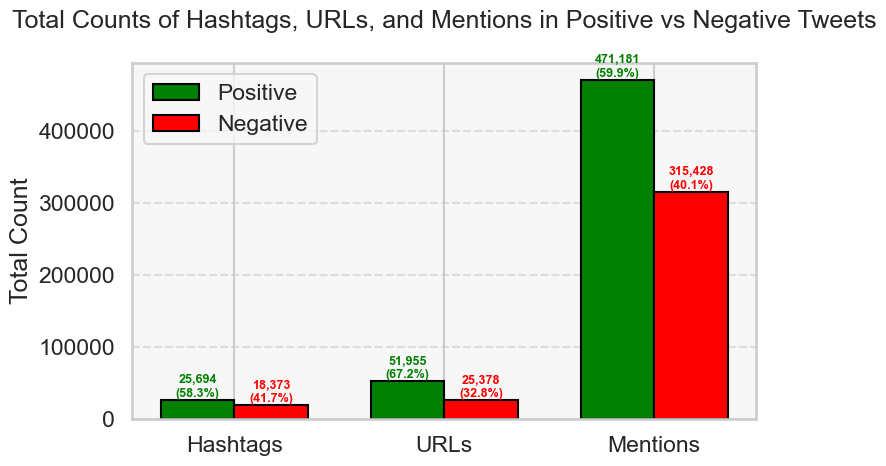

In [7]:
def compare_total_features(df):
    """
    Display bar charts comparing the total number of hashtags, URLs,
    and mentions (@) in positive vs negative tweets, with counts and percentages.

    Args:
        df (pd.DataFrame): DataFrame with ['sentiment', 'tweet'] columns.

    Returns:
        dict: Dictionary with total counts and percentages for each feature.
    """

    # Define regex patterns
    patterns = {
        'Hashtags': r"#\w+",
        'URLs': r"http[s]?://\S+|www\.\S+",
        'Mentions': r"@\w+"
    }

    # Initialize results
    results = {}

    # Count each feature per tweet
    for feature, pattern in patterns.items():
        df[f'{feature.lower()}_count'] = df['tweet'].astype(str).apply(lambda x: len(re.findall(pattern, x)))

        # Totals per sentiment
        total_pos = df.loc[df['sentiment'] == 4, f'{feature.lower()}_count'].sum()
        total_neg = df.loc[df['sentiment'] == 0, f'{feature.lower()}_count'].sum()

        total_all = total_pos + total_neg
        perc_pos = (total_pos / total_all * 100) if total_all > 0 else 0
        perc_neg = (total_neg / total_all * 100) if total_all > 0 else 0

        results[feature] = {
            'positive': {'count': total_pos, 'percentage': perc_pos},
            'negative': {'count': total_neg, 'percentage': perc_neg}
        }

    # ---- Plot ----
    features = list(patterns.keys())
    positive_counts = [results[f]['positive']['count'] for f in features]
    negative_counts = [results[f]['negative']['count'] for f in features]
    positive_percs = [results[f]['positive']['percentage'] for f in features]
    negative_percs = [results[f]['negative']['percentage'] for f in features]

    x = range(len(features))
    width = 0.35

    plt.figure(figsize=(8, 5))
    bars1 = plt.bar([p - width/2 for p in x], positive_counts, width, color='green', edgecolor='black', label='Positive')
    bars2 = plt.bar([p + width/2 for p in x], negative_counts, width, color='red', edgecolor='black', label='Negative')

    # Add labels (count + %)
    for bar, count, perc in zip(bars1, positive_counts, positive_percs):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{count:,}\n({perc:.1f}%)",
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='green'
        )

    for bar, count, perc in zip(bars2, negative_counts, negative_percs):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{count:,}\n({perc:.1f}%)",
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='red'
        )

    # Formatting
    plt.xticks(x, features)
    plt.title("Total Counts of Hashtags, URLs, and Mentions in Positive vs Negative Tweets\n")
    plt.ylabel("Total Count")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

compare_total_features(df)

### Ponctuation ( ? , ! , ... )

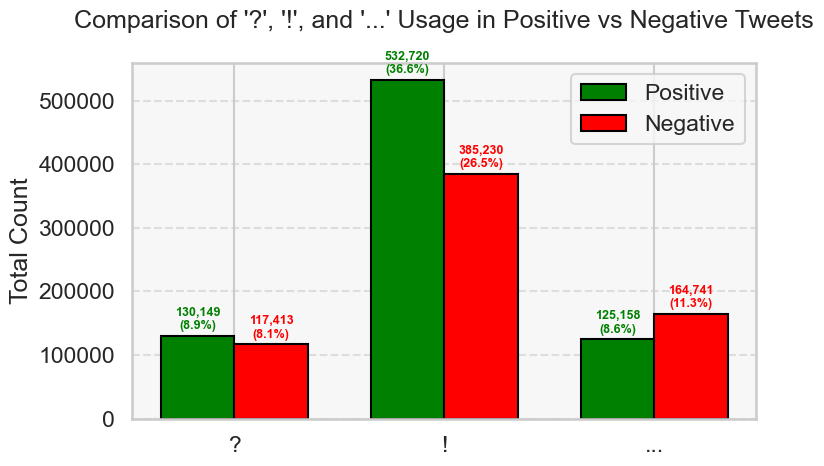

In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

def compare_punctuation_usage(df):
    """
    Count and compare the use of '?', '!', and '...' in positive vs negative tweets,
    displaying both counts and percentages on the bars.
    Also creates columns for each punctuation count per tweet.

    Args:
        df (pd.DataFrame): DataFrame with ['sentiment', 'tweet'] columns.

    Returns:
        pd.DataFrame: Summary table with punctuation counts and percentages by sentiment.
    """

    # Define regex patterns for punctuation features
    patterns = {
        '?': r"\?",
        '!': r"!",
        '...': r"\.\.\."
    }

    # --- Add per-tweet punctuation count columns ---
    df['question_count'] = df['tweet'].astype(str).apply(lambda x: len(re.findall(patterns['?'], x)))
    df['exclamation_count'] = df['tweet'].astype(str).apply(lambda x: len(re.findall(patterns['!'], x)))
    df['ellipsis_count'] = df['tweet'].astype(str).apply(lambda x: len(re.findall(patterns['...'], x)))

    # Filter tweets by sentiment
    pos_tweets = df[df['sentiment'] == 4]
    neg_tweets = df[df['sentiment'] == 0]

    # Count total occurrences for each punctuation and sentiment
    counts = {
        'positive': {
            '?': pos_tweets['question_count'].sum(),
            '!': pos_tweets['exclamation_count'].sum(),
            '...': pos_tweets['ellipsis_count'].sum()
        },
        'negative': {
            '?': neg_tweets['question_count'].sum(),
            '!': neg_tweets['exclamation_count'].sum(),
            '...': neg_tweets['ellipsis_count'].sum()
        }
    }

    # Create DataFrame for easier plotting
    summary_df = pd.DataFrame(counts).T  # transpose so rows = sentiment

    # Compute percentages (relative to total punctuation occurrences)
    total_all = summary_df.sum().sum()
    summary_perc = (summary_df / total_all) * 100

    # --- Visualization ---
    features = ['?', '!', '...']
    x = np.arange(len(features))  # positions
    width = 0.35

    plt.figure(figsize=(8, 5))
    bars_pos = plt.bar(x - width/2, summary_df.loc['positive', features], width,
                       label='Positive', color='green', edgecolor='black')
    bars_neg = plt.bar(x + width/2, summary_df.loc['negative', features], width,
                       label='Negative', color='red', edgecolor='black')

    # Add labels above bars (count + percentage)
    for i, f in enumerate(features):
        pos_count = summary_df.loc['positive', f]
        neg_count = summary_df.loc['negative', f]
        pos_perc = summary_perc.loc['positive', f]
        neg_perc = summary_perc.loc['negative', f]

        plt.text(x[i] - width/2, pos_count + max(summary_df.values.flatten())*0.01,
                 f"{pos_count:,}\n({pos_perc:.1f}%)",
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='green')
        plt.text(x[i] + width/2, neg_count + max(summary_df.values.flatten())*0.01,
                 f"{neg_count:,}\n({neg_perc:.1f}%)",
                 ha='center', va='bottom', fontsize=9, fontweight='bold', color='red')

    plt.xticks(x, features)
    plt.title("Comparison of '?', '!', and '...' Usage in Positive vs Negative Tweets\n")
    plt.ylabel("Total Count")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

compare_punctuation_usage(df)


### UpperCases

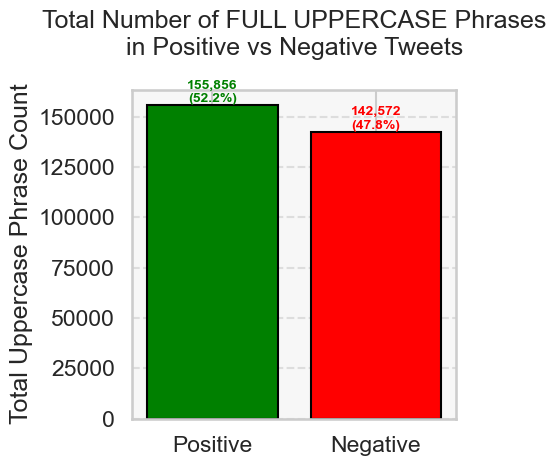

In [9]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def compare_total_uppercase_phrases(df):
    """
    Display a bar chart comparing the total number of fully UPPERCASE phrases
    in positive vs negative tweets, with counts and percentages shown.

    Args:
        df (pd.DataFrame): DataFrame with ['sentiment', 'tweet'] columns.

    Returns:
        dict: Dictionary with total counts and percentages for uppercase phrases.
    """

    # Regex: finds sequences of at least 2 uppercase letters (optionally multiple words)
    uppercase_pattern = r"\b(?:[A-Z]{2,}(?:\s+[A-Z]{2,})*)\b"

    # Count uppercase phrases per tweet
    df['uppercase_count'] = df['tweet'].astype(str).apply(lambda x: len(re.findall(uppercase_pattern, x)))

    # Totals by sentiment
    total_positive = df.loc[df['sentiment'] == 4, 'uppercase_count'].sum()
    total_negative = df.loc[df['sentiment'] == 0, 'uppercase_count'].sum()

    # Percentages
    total_all = total_positive + total_negative
    perc_positive = (total_positive / total_all * 100) if total_all > 0 else 0
    perc_negative = (total_negative / total_all * 100) if total_all > 0 else 0

    # Data for plotting
    sentiments = ['Positive', 'Negative']
    totals = [total_positive, total_negative]
    percentages = [perc_positive, perc_negative]

    # Plot (same style as before)
    plt.figure(figsize=(5, 5))
    bars = plt.bar(sentiments, totals, color=['green', 'red'], edgecolor='black')

    # Add labels (count + %)
    for bar, count, perc, color in zip(bars, totals, percentages, ['green', 'red']):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{count:,}\n({perc:.1f}%)",
            ha='center', va='bottom', fontsize=10, fontweight='bold', color=color
        )

    # Formatting
    plt.title("Total Number of FULL UPPERCASE Phrases\nin Positive vs Negative Tweets\n")
    plt.ylabel("Total Uppercase Phrase Count")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

compare_total_uppercase_phrases(df)

In [10]:
df.head() # The corresponding columns were created when running previous analysis functions to keep those as features.

,sentiment,id,date,query,user,tweet,text_length,word_count,neg_form_count,hashtags_count,urls_count,mentions_count,question_count,exclamation_count,ellipsis_count,uppercase_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,19,0,0,1,1,0,0,0,0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111,21,1,0,0,0,0,1,1,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89,18,0,0,0,1,0,0,0,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47,10,0,0,0,0,0,0,0,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111,21,3,0,0,1,1,0,0,0


### Lexical analysing interpreting

**🧠 Summary of Tweet Data Analysis**

**1. FULL UPPERCASE Phrase Usage**

* **Positive tweets (52.2%)** use slightly more **fully uppercase phrases** than negative tweets (47.8%).
* This suggests that **positive users express enthusiasm and excitement** (e.g., “LOVE IT”, “SO HAPPY”) using uppercase, while negative tweets may express anger or frustration but with slightly lower emphasis.

---

**2. Punctuation Usage (`?`, `!`, `...`)**

* **Exclamation marks (`!`)** are **most frequent in positive tweets (36.6%)**, reinforcing the idea of **emotional excitement or joy**.
* **Question marks (`?`)** appear almost equally between sentiments, showing similar curiosity or rhetorical questioning across tones.
* **Ellipses (`...`)** are more frequent in **negative tweets (11.3%)**, which may reflect **hesitation, disappointment, or sarcasm**.

**➡️ Interpretation:**
Positive tweets tend to be more expressive and enthusiastic (more `!`), whereas negative tweets use ellipses more often to convey frustration or trailing thoughts.

---

**3. Hashtags, URLs, and Mentions**

* **Mentions (@)** dominate overall, especially in **positive tweets (59.9%)**, suggesting positive users engage more directly with others (social interaction, appreciation).
* **URLs** also appear more in positive tweets (67.2%), possibly linking to positive content or promotions.
* **Hashtags** are used more in positive tweets (58.3%) as well, reflecting **broader topic sharing and engagement**.

**➡️ Interpretation:**
Positive tweets are generally **more interactive and outward-facing**, while negative tweets are less likely to include external links or social references.

---

**4. Emoticon Sentiment (within Negative Tweets)**

* Even in **negative tweets**, **positive emoticons (69%)** appear more often than negative ones (31%).
* This shows that **emoticon usage doesn’t always align perfectly with sentiment**, and people often use emojis to **soften negativity**.

---

**5. Emoticon Sentiment (within Positive Tweets)**

* **Positive emoticons dominate (87.4%)**, with few negative ones (12.6%).
* This reinforces that **positive sentiment tweets rely heavily on emoticons** to visually convey happiness, excitement, or friendliness.

---

**6. Use of Negative Forms (e.g., “not”, “never”, “don’t”)**

* **Negative tweets (69%)** contain far more **negative linguistic forms** than positive ones (31%).
* This clearly reflects **linguistic polarity**, showing that sentiment classification aligns well with actual lexical cues.

---

**7. Tweet Structure & Length (Boxplots)**

* **Word count and character length distributions** are **similar** across sentiments.
* Positive and negative tweets show **comparable tweet sizes**, with no major difference in verbosity or message length.

**➡️ Interpretation:**
The emotional polarity of tweets is expressed **more through style (punctuation, emoticons, uppercase)** than through the amount of text.

---

💡 Distinguishing Features Between Positive and Negative Tweets

✅ **Features that Clearly Distinguish Sentiments**

| Feature                                                 | Observation                                                                                  | Interpretation                                                                                              |
| ------------------------------------------------------- | -------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| **Exclamation marks (`!`)**                             | Strongly more frequent in **positive** tweets (≈ +10% difference).                           | Indicates **excitement, joy, and enthusiasm** — a strong emotional marker of positivity.                    |
| **Hashtags / Mentions / URLs**                          | All appear **significantly more often in positive** tweets.                                  | Positive tweets are **more social and interactive**, likely promotional, appreciative, or community-driven. |
| **Positive emoticons**                                  | Vastly higher in **positive** tweets (≈ 87%) and still dominant even inside negative tweets. | A powerful **non-textual indicator** of happiness or friendliness.                                          |
| **Negative linguistic forms** (“not”, “never”, “don’t”) | Much more common in **negative** tweets (≈ +38% difference).                                 | A direct **lexical marker of negativity** — highly discriminative.                                          |




⚖️ **Features That Do *Not* Distinguish Strongly**

| Feature                       | Observation                                               | Interpretation                                                                                      |
| ----------------------------- | --------------------------------------------------------- | --------------------------------------------------------------------------------------------------- |
| **Question marks (`?`)**      | Almost equal across positive and negative tweets.         | Expresses curiosity or confusion in both moods — **not sentiment-specific**.                        |
| **Ellipses (`...`)**          | Slightly higher in negative tweets, but overlap is large. | Mild tendency toward frustration or hesitation, but **not a strong classifier**.                    |
| **Tweet length & word count** | Distributions are nearly identical between sentiments.    | **Length is not a sentiment signal** — users express both positive and negative emotions concisely. |
| **Uppercase usage**           | Difference exists but small (≈ 4%).                       | Adds nuance, but **alone not sufficient** to infer sentiment.                                       |
| **Negative emoticons**                                  | Higher in **positive** tweets (≈ 69%) than negative tweets (≈ 31%). | people tend to use them even for negative tweets  |

---
✨ **Conclusion**

Positive tweets tend to be **more expressive, interactive, and emotionally rich**, using punctuation, uppercase, and emoticons to convey enthusiasm.
Negative tweets, on the other hand, exhibit **more restrained but linguistically negative tone**, with ellipses and negations hinting at frustration or discontent.

# CLEANING TEXT

## Preprocessing

✅ Preprocessing steps(preparing for TF-IDF + Logistic Regression)

- Lowercase
- Expand contractions
- Convert emoticons → words
- Convert emojis → words ✅
- Remove URLs, mentions, hashtags, special chars, and punctuation
- Tokenize
- Remove stopwords
- Lemmatize
- Join tokens back (for TF-IDF)

In [ ]:
# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize tools
stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()  ##############################
stemmer = nltk.PorterStemmer()
spell = Speller(lang='en')

# --- Emoticon dictionary
emoticon_dict = {
    ':)': 'smile', ':-)': 'smile', ':(': 'sad', ':-(': 'sad',
    ':d': 'laugh', ':-d': 'laugh', ';)': 'wink', ';-)': 'wink',
    ':/': 'annoyed', ':p': 'playful', ':-p': 'playful',
    ":'(": 'cry', 'xd': 'laugh', 't_t': 'cry'
}

# --- Contractions dictionary
contractions = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot",
    "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it's": "it is",
    "let's": "let us", "shouldn't": "should not", "that's": "that is",
    "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "wasn't": "was not",
    "we'd": "we would", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what's": "what is", "where's": "where is",
    "who's": "who is", "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have", "gonna": "going to", "wanna": "want to"
}

# --- Contraction expansion
def expand_contractions(text, contractions_dict):
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    return pattern.sub(lambda x: contractions_dict[x.group()], text)

# --- Emoji conversion
def convert_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # 😊 -> ' smile '

# --- Main preprocessing function
def preprocess_tweet(text):
    # 1️⃣ Lowercase
    text = text.lower()

    # 2️⃣ Expand contractions
    text = expand_contractions(text, contractions)

    # 3️⃣ Convert emoticons to words
    for emoticon, meaning in emoticon_dict.items():
        text = text.replace(emoticon, f" {meaning} ")

    # 4️⃣ Convert emojis to words
    text = convert_emojis(text)

    # 6️⃣ Remove URLs, mentions, hashtags, punctuation, etc.
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'\bhttps?\b', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[\?\!\.]', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()

    # 7️⃣ Tokenize
    tokens = nltk.word_tokenize(text)

    # 8️⃣ Remove stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    # 9️⃣ Lemmatize
    # tokens = [lemmatizer.lemmatize(word) for word in tokens] 
    tokens = [stemmer.stem(word) for word in tokens]  ##############################

    # 🔟 Join back to string for TF-IDF
    return " ".join(tokens)

# Assuming your DataFrame is named df
df['tweet'] = df['tweet'].swifter.apply(preprocess_tweet)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kamel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kamel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kamel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Pandas Apply: 100%|██████████| 1600000/1600000 [06:56<00:00, 3839.39it/s]


In [14]:
df.head()

,sentiment,id,date,query,user,tweet,text_length,word_count,neg_form_count,hashtags_count,urls_count,mentions_count,question_count,exclamation_count,ellipsis_count,uppercase_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,annoy twitpiccom 2y1zl awww bummer shoulda got...,115,19,0,0,1,1,0,0,0,0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset updat facebook text might cri result sch...,111,21,1,0,0,0,0,1,1,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dive mani time ball manag save 50 rest go bound,89,18,0,0,0,1,0,0,0,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole bodi feel itchi like fire,47,10,0,0,0,0,0,0,0,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behav mad see,111,21,3,0,0,1,1,0,0,0


## Backup

In [15]:
df.to_csv('../sentiment140/processed_data/stemmed_tweets.csv', index=False)

## Sampling

In [3]:
df_complet = pd.read_csv("../../sentiment140/processed_data/stemmed_tweets.csv", encoding='latin-1')

# Stratified sampling to have tweets of the two sentiments
df_negatifs = df_complet[df_complet['sentiment'] == 0].sample(8000, random_state=42)
df_positifs = df_complet[df_complet['sentiment'] == 4].sample(8000, random_state=42)

# So we get a sample of 10% of the original dataset
df_sample = pd.concat([df_negatifs, df_positifs]).reset_index(drop=True)
df_sample.head()

,sentiment,id,date,query,user,tweet,text_length,word_count,neg_form_count,hashtags_count,urls_count,mentions_count,question_count,exclamation_count,ellipsis_count,uppercase_count
0,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,oh order horribl,59,10,1,0,0,1,1,1,0,0
1,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,great hard train weekend coupl day rest let lo...,121,25,0,0,0,0,0,1,0,0
2,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,right work hour go free laugh,56,13,0,0,0,0,0,0,0,0
3,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,crave japanes food,31,6,0,0,0,0,0,0,0,0
4,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,jean michel jarr concert tomorrow got ta work ...,65,10,0,0,0,0,0,0,0,0


In [4]:
df_sample.shape

(16000, 16)

## TF-IDF features

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf = TfidfVectorizer(
    max_features=1000,   # tune based on memory
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95
)

# Fit and transform
df_sample['tweet'] = df_sample['tweet'].fillna('')
X_tfidf = tfidf.fit_transform(df_sample['tweet'])
print(f"TF-IDF shape: {X_tfidf.shape}")


TF-IDF shape: (16000, 1000)


In [6]:
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=[f"tfidf_{w}" for w in tfidf.get_feature_names_out()],
    index=df_sample.index
)

# Example: drop text & categorical columns
numeric_df = df_sample.drop(columns=['tweet'])   # drop tweet text (and any categoricals)

# Concatenate side by side
final_df = pd.concat([numeric_df, tfidf_df], axis=1)
final_df.head()


,sentiment,id,date,query,user,text_length,word_count,neg_form_count,hashtags_count,urls_count,...,tfidf_year,tfidf_yep,tfidf_yesterday,tfidf_yet,tfidf_youtub,tfidf_yr,tfidf_yummi,tfidf_yup,tfidf_â½,tfidf_â¾ã
0,0,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,59,10,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,121,25,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,56,13,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,31,6,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,65,10,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
final_df = final_df.drop(['id', 'date', 'query', 'user'], axis=1)
final_df.head()

,sentiment,text_length,word_count,neg_form_count,hashtags_count,urls_count,mentions_count,question_count,exclamation_count,ellipsis_count,...,tfidf_year,tfidf_yep,tfidf_yesterday,tfidf_yet,tfidf_youtub,tfidf_yr,tfidf_yummi,tfidf_yup,tfidf_â½,tfidf_â¾ã
0,0,59,10,1,0,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,121,25,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,56,13,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,31,6,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,65,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
final_df.shape

(16000, 1011)

# Modeling

**Regression Logisitique**

Hyperparametres à optimiser:

- **penalty :** Type de régularisation : 'l1', 'l2', 'elasticnet', ou 'none' (intervient dans la fonction de coût)

- **l1_ratio :** Ratio entre L1 et L2 pour 'elasticnet'

- **C :** Force de la régularisation (inverse du paramètre de pénalisation λ) – plus C est grand, moins il y a de régularisation (intervient dans la fonction de coût)

- **solver :** Méthode d’optimisation : 'liblinear', 'lbfgs', 'newton-cg', 'saga'

- **max_iter :** Nombre max d’itérations pour la convergence

- **fit_intercept :** Est-ce qu’on apprend un biais (True) ou pas (False) ?

## Running

In [14]:
# ===========================================
# Logistic Regression + Optuna + MLflow (5-Fold CV + tracés complets)
# ===========================================
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import optuna
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

# ------------------------------
# 0) CONFIG
# ------------------------------
EXPERIMENT_NAME = "Tweet_Sentiment_LogReg_Optuna_KFold"
TARGET_COL      = "sentiment"
PARALLEL_MODE   = -1
N_TRIALS        = 10
N_FOLDS         = 5

# ------------------------------
# 1) DATA
# ------------------------------
X = final_df.drop(columns=[TARGET_COL])
y = final_df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ------------------------------
# 2) SCALERS
# ------------------------------
scaler_configs = {
    "NoScaler": None,
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler()
}

# ------------------------------
# 3) VALID COMBOS
# ------------------------------
def is_valid_combination(params: dict) -> bool:
    solver  = params["solver"]
    penalty = params["penalty"]

    if penalty == "l1" and solver not in ("liblinear", "saga"):
        return False
    if penalty == "elasticnet" and solver != "saga":
        return False
    if penalty is None and solver not in ("lbfgs", "newton-cg", "saga"):
        return False
    return True

# ------------------------------
# 4) OBJECTIVE (Optuna avec CV)
# ------------------------------
def objective(trial, scaler_name, Xtr, ytr, parent_run_id, exp_id):
    # Hyperparams
    params = {
        "solver": trial.suggest_categorical("solver", ["liblinear", "lbfgs", "newton-cg", "saga"]),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", None]),
        "C": trial.suggest_float("C", 1e-3, 10.0, log=True),
        "max_iter": trial.suggest_int("max_iter", 200, 1000),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "random_state": 42,
    }
    if params["penalty"] == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)

    if not is_valid_combination(params):
        raise optuna.TrialPruned()

    with mlflow.start_run(run_name=f"trial_{trial.number}", nested=True) as child_run:
        child_id = child_run.info.run_id

        mlflow.set_tag("mlflow.parentRunId", parent_run_id)
        mlflow.set_tag("scaler", scaler_name)
        mlflow.set_tag("trial_number", trial.number)

        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
        f1_scores, acc_scores, prec_scores, rec_scores = [], [], [], []

        for fold, (train_idx, val_idx) in enumerate(skf.split(Xtr, ytr)):
            X_train_fold, X_val_fold = Xtr[train_idx], Xtr[val_idx]
            y_train_fold, y_val_fold = ytr.iloc[train_idx], ytr.iloc[val_idx]

            try:
                model = LogisticRegression(**params)
                model.fit(X_train_fold, y_train_fold)
                y_pred = model.predict(X_val_fold)
            except ValueError as e:
                print(f"⚠️ Invalid combo (fold {fold}) — {e}")
                raise optuna.TrialPruned()

            acc  = accuracy_score(y_val_fold, y_pred)
            f1   = f1_score(y_val_fold, y_pred, average="weighted")
            prec = precision_score(y_val_fold, y_pred, average="weighted")
            rec  = recall_score(y_val_fold, y_pred, average="weighted")

            acc_scores.append(acc)
            f1_scores.append(f1)
            prec_scores.append(prec)
            rec_scores.append(rec)

        # Moyennes des folds
        mean_acc  = np.mean(acc_scores)
        mean_f1   = np.mean(f1_scores)
        mean_prec = np.mean(prec_scores)
        mean_rec  = np.mean(rec_scores)

        # Log des moyennes vers le child run
        mlflow.log_params(params)
        mlflow.log_metrics({
            "cv_accuracy": mean_acc,
            "cv_f1": mean_f1,
            "cv_precision": mean_prec,
            "cv_recall": mean_rec
        })

        # 🟢 Log des métriques dans le parent run (traçage par step)
        step = trial.number
        mlflow.log_metric("cv_f1_trace", mean_f1, step=step, run_id=parent_run_id)
        mlflow.log_metric("cv_accuracy_trace", mean_acc, step=step, run_id=parent_run_id)
        mlflow.log_metric("cv_precision_trace", mean_prec, step=step, run_id=parent_run_id)
        mlflow.log_metric("cv_recall_trace", mean_rec, step=step, run_id=parent_run_id)

        trial.set_user_attr("params", params)
        trial.set_user_attr("mlflow_run_id", child_id)

        return mean_f1  # objectif: maximiser le F1 CV moyen

# ------------------------------
# 5) MAIN LOOP
# ------------------------------
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
exp_id = experiment.experiment_id
client = MlflowClient()

for scaler_name, scaler in scaler_configs.items():
    print(f"\n🏁 Optuna (5-Fold CV) pour {scaler_name}")

    if scaler is None:
        Xtr = X_train.values
    else:
        Xtr = scaler.fit_transform(X_train)

    with mlflow.start_run(run_name=f"Optuna_{scaler_name}_Parent") as parent_run:
        parent_id = parent_run.info.run_id
        mlflow.set_tag("scaler", scaler_name)

        study = optuna.create_study(direction="maximize", study_name=f"LogReg_{scaler_name}_CV_Study")

        study.optimize(
            lambda t: objective(t, scaler_name, Xtr, y_train, parent_id, exp_id),
            n_trials=N_TRIALS,
            n_jobs=PARALLEL_MODE
        )

        best_trial  = study.best_trial
        best_f1_val = best_trial.value
        best_params = best_trial.user_attrs.get("params", best_trial.params)
        best_trial_no = best_trial.number
        best_child_run_id = best_trial.user_attrs.get("mlflow_run_id", None)

        mlflow.log_metric("best_cv_f1", best_f1_val, run_id=parent_id)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        mlflow.set_tag("best_trial_number", best_trial_no)

        if best_child_run_id is not None:
            client.set_tag(best_child_run_id, "best_model", "True")

        # Test final sur jeu de test
        if scaler is None:
            X_train_full = Xtr
            X_test_scaled = X_test
        else:
            X_train_full = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

        best_model = LogisticRegression(**best_params)
        best_model.fit(X_train_full, y_train)
        y_pred_test = best_model.predict(X_test_scaled)

        test_acc  = accuracy_score(y_test, y_pred_test)
        test_f1   = f1_score(y_test, y_pred_test, average="weighted")
        test_prec = precision_score(y_test, y_pred_test, average="weighted")
        test_rec  = recall_score(y_test, y_pred_test, average="weighted")

        mlflow.log_metrics({
            "test_accuracy": test_acc,
            "test_f1": test_f1,
            "test_precision": test_prec,
            "test_recall": test_rec
        })

        cm = confusion_matrix(y_test, y_pred_test)
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
        ax.figure.colorbar(im, ax=ax)
        ax.set(
            xticks=[0, 1],
            yticks=[0, 1],
            xticklabels=["Prédit négatif", "Prédit positif"],
            yticklabels=["Réel négatif", "Réel positif"],
            ylabel="Réel",
            xlabel="Prédit",
            title=f"Matrice de confusion - {scaler_name}"
        )
        labels = [["TN", "FP"], ["FN", "TP"]]
        for i in range(2):
            for j in range(2):
                ax.text(j, i, f"{labels[i][j]} = {cm[i, j]}", ha="center", va="center", color="black")
        fig.tight_layout()
        mlflow.log_figure(fig, f"confusion_matrix_{scaler_name}.png")
        plt.close(fig)

        try:
            import plotly
            fig1 = optuna.visualization.plot_optimization_history(study)
            mlflow.log_figure(fig1, "optimization_history.html")
            fig2 = optuna.visualization.plot_param_importances(study)
            mlflow.log_figure(fig2, "param_importance.html")
        except ImportError:
            print("⚠️ Plotly non installé — visualisations sautées.")

        print(f"✅ {scaler_name}: Best CV F1={best_f1_val:.4f} | Test F1={test_f1:.4f}")
        print(f"🏆 Best Params: {best_params}")


[I 2025-11-17 11:18:10,189] A new study created in memory with name: LogReg_NoScaler_CV_Study
[I 2025-11-17 11:18:10,194] Trial 2 pruned. 
[I 2025-11-17 11:18:10,209] Trial 5 pruned. 
[I 2025-11-17 11:18:10,212] Trial 8 pruned. 



🏁 Optuna (5-Fold CV) pour NoScaler


[I 2025-11-17 11:18:39,527] Trial 7 finished with value: 0.7367140682162819 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.6301926693810218, 'max_iter': 911, 'fit_intercept': True}. Best is trial 7 with value: 0.7367140682162819.
[I 2025-11-17 11:19:10,988] Trial 6 finished with value: 0.6818964087195021 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.028374136949776477, 'max_iter': 731, 'fit_intercept': False}. Best is trial 7 with value: 0.7367140682162819.
[I 2025-11-17 11:19:43,229] Trial 9 finished with value: 0.7340419948423653 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.3912578412584737, 'max_iter': 341, 'fit_intercept': False}. Best is trial 7 with value: 0.7367140682162819.
[I 2025-11-17 11:20:04,366] Trial 0 finished with value: 0.7342157994618491 and parameters: {'solver': 'lbfgs', 'penalty': None, 'C': 0.7342309729276599, 'max_iter': 474, 'fit_intercept': False}. Best is trial 7 with value: 0.7367140682162819.
[I 2025-11-17 11:20

✅ NoScaler: Best CV F1=0.7367 | Test F1=0.7525
🏆 Best Params: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.6301926693810218, 'max_iter': 911, 'fit_intercept': True, 'random_state': 42}

🏁 Optuna (5-Fold CV) pour StandardScaler


[I 2025-11-17 11:21:59,846] Trial 3 finished with value: 0.7259787344576425 and parameters: {'solver': 'lbfgs', 'penalty': None, 'C': 0.4280637397342125, 'max_iter': 948, 'fit_intercept': True}. Best is trial 3 with value: 0.7259787344576425.
[I 2025-11-17 11:22:04,696] Trial 2 finished with value: 0.7255048282820937 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1482166654178556, 'max_iter': 446, 'fit_intercept': False}. Best is trial 3 with value: 0.7259787344576425.
[I 2025-11-17 11:22:05,349] Trial 6 finished with value: 0.7259802507756934 and parameters: {'solver': 'newton-cg', 'penalty': None, 'C': 0.8130596605135131, 'max_iter': 807, 'fit_intercept': True}. Best is trial 6 with value: 0.7259802507756934.
[I 2025-11-17 11:22:08,501] Trial 1 finished with value: 0.636267252076609 and parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'C': 0.0026366898080789304, 'max_iter': 838, 'fit_intercept': True, 'l1_ratio': 0.896510251740289}. Best is trial 6 with value:

✅ StandardScaler: Best CV F1=0.7260 | Test F1=0.7375
🏆 Best Params: {'solver': 'newton-cg', 'penalty': None, 'C': 0.8130596605135131, 'max_iter': 807, 'fit_intercept': True, 'random_state': 42}

🏁 Optuna (5-Fold CV) pour MinMaxScaler


[I 2025-11-17 11:22:14,463] Trial 8 finished with value: 0.7367705282033714 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.3325425243224849, 'max_iter': 757, 'fit_intercept': True}. Best is trial 8 with value: 0.7367705282033714.
[I 2025-11-17 11:22:17,904] Trial 9 finished with value: 0.7373217251173285 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.33612035510187005, 'max_iter': 287, 'fit_intercept': True}. Best is trial 9 with value: 0.7373217251173285.
[I 2025-11-17 11:22:23,132] Trial 0 finished with value: 0.7261331960857053 and parameters: {'solver': 'lbfgs', 'penalty': None, 'C': 2.0416725781067244, 'max_iter': 452, 'fit_intercept': True}. Best is trial 9 with value: 0.7373217251173285.
[I 2025-11-17 11:22:24,752] Trial 4 finished with value: 0.7259015129717765 and parameters: {'solver': 'newton-cg', 'penalty': None, 'C': 1.4247271657768874, 'max_iter': 595, 'fit_intercept': True}. Best is trial 9 with value: 0.7373217251173285.
[I 2025-11-17 11:22

✅ MinMaxScaler: Best CV F1=0.7373 | Test F1=0.7490
🏆 Best Params: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.33612035510187005, 'max_iter': 287, 'fit_intercept': True, 'random_state': 42}


# End

# Taches à faire